# Introduction
This notebook is basic EDA for the `kc_house_data.csv` file. I create a data frame, check data types for logical consistency (no numbers as strings, etc.), make preliminary observations on the data, and return a finished `cleaned_kc.csv` file to be used in the final project.

## Importing Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import datetime

In [2]:
df = pd.read_csv('data/kc_house_data.csv')

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


## Column Names And Meanings

In [4]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

Most of the column names make sense intuitively, or are explained decently in the supplementary `column_names.md` file. 

Columns `condition` and `grade` seem to be redundant, but [this](https://www.slideshare.net/PawanShivhare1/predicting-king-county-house-prices) project found through Kaggle asserts that `condition` speaks to the "condition of the apartment" and `grade` speaks to the "level of [building] construction and design." Still unclear, but I think that `condition` is more for a single unit and `condition` is for a whole apartment complex. Then again, the .csv file is named `house_data`. Hard to define a meaning here, but that doesn't mean these numbers are useless in analysis

In [5]:
df.view.describe()

count    21534.000000
mean         0.233863
std          0.765686
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: view, dtype: float64

Moreover, the `view` column does not make sense when compared to its description in `markdown.md`, which simply states "Has been viewed." This would imply a boolean column where **True** indicates having-been-viewed. Instead, the column is integers 0-4:

In [6]:
sorted(df.view.unique())

[0.0, nan, 1.0, 2.0, 3.0, 4.0]

Does this then indicate a *number of times* viewed instead of just yes-no? If so, why does it stop at 4? I would think personally that this 0-4 is actually a 1-5 rating system based on user reviews of a house showing. Either way, the column is almost entirely zeros, as seen below. I'm going to drop this column because of its ambiguity.

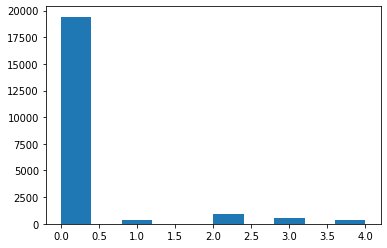

In [7]:
plt.hist(df.view);

In [8]:
df.drop('view', axis=1, inplace=True)

## Data Types

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(7), int64(11), object(2)
memory usage: 3.3+ MB


Some of these data types don't make sense and need to be changed. I will convert `date` to a date-time format and `sqft_basement` to a float. Column `sqft_basement` has an erroneous '?' value that also has to be accounted for.

In [10]:
print(sorted(df.sqft_basement.unique(), reverse=1)[0])

for a in ['?', '0.0']:
    print(len(df[df.sqft_basement == a]) / len(df) * 100)

?
2.1021438162707784
59.387877946011024


Only 2% of basement sizes are unknown. 59% of houses didn't have basements. The '?' values will be replaced with zeros. Then the whole column is cast as numeric (float).

In [11]:
no_qmark = df.sqft_basement.replace('?', '0.0')
df.sqft_basement = no_qmark

In [12]:
df.sqft_basement = pd.to_numeric(df.sqft_basement)

Now replace those date strings with the datetime data type.

In [13]:
df.date = pd.to_datetime(df.date)

## Duplicates

In [14]:
dupe_rows = df[df.duplicated()]
len(dupe_rows)

0

No full-row duplicates in the data set. What about recycled ID's?

In [15]:
dupe_id = df[df.id.duplicated()]
print(len(dupe_id), np.round(1-(len(df)-len(dupe_id))/len(df), 2))

177 0.01


177 is a small percentage (0.01) of our data set. These may be houses that were resold. Either way, I will drop these rows because they are so few.

In [16]:
df.drop_duplicates(subset='id', inplace=True)

No other rows have values which would produce meaningful duplicates. In other words, things like `price`, `date`, and `waterfront` are not unique, and can be ignored here.

## Missing And Zero Values

In [17]:
np.sum(df.isna())

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2353
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3804
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

The columns `waterfront` and `yr_renovated` both contain a decent number of NaN's. Let's look at their unique values and distributions to see how this should be addressed.

[nan  0.  1.]


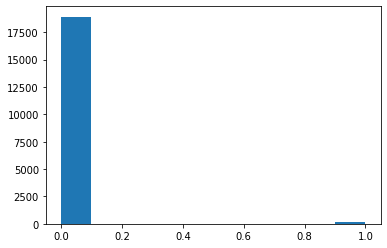

In [18]:
print(df.waterfront.unique())
plt.hist(df.waterfront);

This one's pretty straightforward. Those 2000-ish NaN's are becoming zeros.

In [19]:
df.waterfront.fillna(0, inplace=True)

Now what about `yr_renovated`?

In [20]:
renovated = df.yr_renovated[df.yr_renovated != 0]
print(len(renovated) / len(df.yr_renovated) * 100)

21.213818860877684


Only about 20% of houses have ever been renovated. It's smarter to turn this into a binary column (where 0 is "Has not been renovated" and 1 is "Has been renovated) than break it into dozens of dummy variables. Also, for NaN values, it is safer to assume that these houses have *not* been renovated, seeing as the mode of this column is 0, when cast as a binary option.

In [21]:
df.yr_renovated.fillna(0, inplace=True)

In [22]:
df.loc[(df.yr_renovated > 0), 'yr_renovated'] = 1

In [23]:
df.rename({'yr_renovated' : 'renovated'}, axis=1, inplace=True)

Double checking we got all the NaN's out of the data.

In [24]:
np.sum(df.isna())

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
renovated        0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## Continuous Variables

It's time to separate categorical and continuous values. Most are fairly obvious in this dataset. From reviewing the rows we can draw some basic assumptions and identify continuous variables. The main one that stands out to me as able to be argued for *either* continuous or categorical is `yr_built`. It all depends on how many years are present in the data.

In [35]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400.0,1951,1.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


116 years


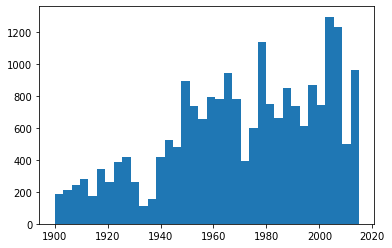

In [37]:
print(df.yr_built.nunique(), 'years')
plt.hist(df.yr_built, bins='auto');

There are 116 unique years in the data set. That's too many to reasonably do dummy variables with. One alternative, if we still wanted categorical sorting, would be to bin it by decade, but that's still 11 new columns. For these reasons, I'm arguing that it be treated as a continuous variable.

With that out of the way, the continuous variables are:

In [39]:
cont = ['date', 'price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
        'yr_built', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

## Categorical Variables

The variables that remain are our categorical ones. They will each be treated differently.

The columns `condition`, `grade` `bed`, `bath`, and (no, not Beyond) `floors` are fine as-is.

The columns `waterfront` and `renovated` have already been handled and made binary.

And the `zipcode` values will be grouped based on [this map](https://aqua.kingcounty.gov/gis/web/VMC/boundaries/zipcodes/zipcodes.pdf) of King County, from the local government's website.

In [ ]:
# GROUP ZIPCODES
# MAKE CAT VAR LIST
# DOUBLE CHECK THAT THE FIRST GROUP OF CAT VAR ACTUALLY ARE OKAY AS-IS

## Multicollinearity

# Appendix: Questions To Self

## Question: What is the range of sale prices?

In [29]:
print("Range of house sales is ${}M.".format((np.max(df.price) - np.min(df.price))/1000000))

Range of house sales is $7.622M.
